In [1]:
import pandas as pd
import numpy as np
from plotly_dataframe import plot 
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from model_selection import rolling_window_validation
from HW import HW
from metrics import metrics
import os
import shutil
from plotly_plt_predictions import plot_predictions
from tqdm import tqdm
from ipywidgets import widgets, interact
import matplotlib.pyplot as plt
from plot_map import choropleth
from IPython.display import clear_output, display

# Forecasting - Food Consumption Score (FCS)

In [2]:
# Load the original data (smoothed data) of the second version of fcs indicator released by wfp.
df = pd.read_csv("../../../Data Sources/Food Consumption Score (FCS)/time-series/Yemen/wfp_fcs-v2-daily-interpolate.csv", header = [0, 1], index_col = 0)
df.index.name = "Datetime"
df.index = pd.to_datetime(df.index)
freq = "D"
df.index.freq = freq
df.columns.names = ["AdminStrata", "Indicator"]
df.head()

AdminStrata,Abyan,Aden,Al Bayda,Al Dhale'e,Al Hudaydah,Al Jawf,Al Maharah,Al Mahwit,Amanat Al Asimah,Amran,...,Hadramaut,Hajjah,Ibb,Lahj,Marib,Raymah,Sa'ada,Sana'a,Shabwah,Taizz
Indicator,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,...,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS
Datetime,,,,,,,,,,,,,,,,,,,,,
2018-07-02,31.158690,16.619519,38.332669,29.194825,20.788151,22.085706,2.892308,16.815145,17.000398,20.446735,...,23.822825,28.361345,25.036668,31.762436,32.596233,54.121774,17.676022,26.917713,16.752289,26.563365
2018-07-03,32.675222,16.370603,43.292084,31.336940,20.692544,23.477196,2.913825,19.833443,17.208166,21.689014,...,23.699881,28.805448,27.102390,32.049499,33.333333,56.722689,17.134560,25.783476,18.257453,29.124005
2018-07-04,33.415597,15.089163,45.128205,33.135157,21.825051,24.864000,2.950408,19.614289,18.070801,25.611124,...,23.103187,30.993706,29.844066,33.106267,36.883683,56.306306,17.454545,25.436047,19.083081,29.427973
2018-07-05,33.531451,15.766521,43.959297,34.554309,21.481693,27.814992,2.247913,19.558566,19.021964,27.922484,...,21.596419,32.905902,29.025363,32.938828,36.897633,56.231003,17.846350,27.421759,20.349533,30.456026
2018-07-06,33.951856,16.870065,44.516521,33.878557,21.076712,28.688245,2.269780,17.608130,19.817567,28.712235,...,20.129084,32.598181,30.692766,33.837934,36.669568,57.324841,18.463057,26.547231,21.107524,31.012517


In [3]:
#plot(fcs, title = "FCS indicator", yaxis = "% of people with poor and borderline FCS", style = "lines")

In [4]:
# Define the desired length of the test set.
TEST = 30
# Define the metric to evaluate the model.
ERROR = "MSE"
# Set boolean parameter to perform an optional grid search.
GRID_SEARCH = True

In [5]:
# Define the training set and the test set.
train = df[:-TEST]  
test = df[-TEST:]

In [6]:
# Create workspace.
dir = "./output"
if not os.path.exists(dir):
    os.makedirs(dir)
else:
    shutil.rmtree(dir)           
    os.makedirs(dir)
    
os.makedirs(dir + "/images")
os.makedirs(dir + "/grid_search")

# Create a txt file where I annotate the above chosen parameters.
with open(dir + "/setting.txt", "w") as f:
    f.write("GRID SEARCH: %s \n" % GRID_SEARCH)
    f.write("TEST: %d \n" % TEST)
    f.write("ERROR: %s \n" % ERROR)

# Holt-Winters' Seasonal Exponential Smoothing (HW) model

The idea behind triple exponential smoothing (Holt-Winters Method) is to apply exponential smoothing to a third component - seasonality, $S$. This means we should not be using this method if our time series is not expected to have seasonality. Three smoothing equations: one for the level, one for trend, and one for seasonality. Given this design outline, such models are divided into two groups: (i) Multiplicative and (ii) Additive. We provide directly the damped versions of two groups (fixing $\phi = 1$ the damped influence is vanished):

- Multiplicative season and additive trend:

$$L_t = \alpha \frac{x_t}{S_{t-s}} + (1 - \alpha)(L_{t-1} + \phi T_{t-1}) \ \ \ \ \ \ \ \ level$$    

$$T_t = \beta (L_t - L_{t-1}) + (1 - \beta) \phi T_{t-1} \ \ \ \ \ \ \ \ trend$$

$$S_t = \gamma \frac{x_t}{L_{t-1} + \phi T_{t-1}} + (1 - \gamma)(S_{t-s}) \ \ \ \ \ \ \ \ season$$    

$$x_{t + h} = (L_t + (\phi + \phi^2 + ... + \phi^h ) T_t)S_{t - s + 1 + (h - 1)_{mod \ s}}$$

- Additive season and additive trend:

$$L_t = \alpha(x_t - S_{t-s}) + (1 - \alpha)(L_{t-1} + \phi T_{t-1}) \ \ \ \ \ \ \ \ level$$    

$$T_t = \beta (L_t - L_{t-1}) + (1 - \beta) T_{t-1} \phi \ \ \ \ \ \ \ \ trend$$

$$S_t = \gamma(x_t - L_{t-1} - \phi T_{t-1}) + (1 - \gamma)(S_{t-s}) \ \ \ \ \ \ \ \ season$$    

$$x_{t + h} = L_t + (\phi + \phi^2 + ... + \phi^h ) T_t + S_{t - s + 1 + (h - 1)_{mod \ s}}$$

In these equations, $\alpha$, $\beta$ and $\gamma$ are smoothing constants whose values lie in the range $[0, 1]$, $s$ indicates the number of observations that make up a seasonal variation, and $x_{t + h}$ represents the prediction value $x$ for the period $t + h$. Analogously to SES and HES methods, the MHW algorithm receives as input a time series and recursively applies the three described equations. Such application should be started at some time in the past, where the values of L, T and S was previously estimated. A simple way to obtain this approximation is through the initialization of level and trend in the same period $s$. Thus, the level can be determined (for both multiplicative and additive season models) from the average of the first station:

$$L_s = \frac{1}{s}(x_1 + x_2, + ... + x_s)$$

The trend can be initialized using two comlete stations:

$$T_s = \frac{1}{s}(\frac{x_{s + 1} - x_1}{s} + \frac{x_{s + 2} - x_2}{s} + ... + \frac{x_{s + s} - x_s}{s})$$

It is now obvious that the recursive method will start after the first season (at the the $s + 1$ point) because the first $s$ points are used to create the initial condition.

The initial seasonal indexes can be computed depending of the tyoe of model:

- Multiplicative season and additive trend:

$$S_1 = \frac{x_1}{L_s}, S_2 = \frac{x_2}{L_s}, ..., S_s = \frac{x_s}{L_s}$$

- Additive season and additive trend:

$$S_1 = x_1 - L_s, S_2 = x_2 - L_s, ..., S_s = x_s - L_s$$

In this implementation we not consider when the trend is multiplicative. For more details: https://www.stat.berkeley.edu/~arturof/Teaching/STAT248/lab10_part1.html

# Optional grid search

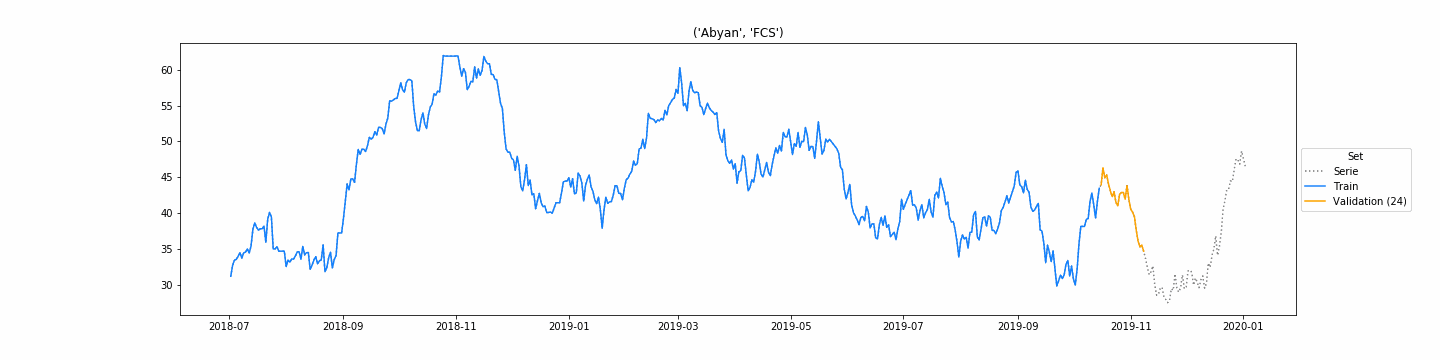

In [7]:
# Define the parameters to grid search.
if GRID_SEARCH:
    validation_type = rolling_window_validation(k_folds = 3, validation_size = 0.05, gap = 0.9, TimeSeriesSplit = False)
    # Show the validation type keeping the first column (time-series).
    _ = validation_type.get_splits(train[train.columns[0]], show = True, path = dir)
    space = {"alpha": hp.uniform("alpha", 1e-5, 0.9999),
             "beta": hp.uniform("beta", 1e-5, 0.9999), 
             "gamma": hp.uniform("gamma", 1e-5, 0.9999), 
             "damped_factor": hp.uniform("damped_factor", 1e-5, 0.999),
             "season": hp.choice("season", ["additive", "multiplicative"]), 
             "s": hp.randint("s", 2, 366), 
             "stationary": hp.choice("stationary", [True, False]),
             "bxcx": hp.choice("bxcx", [True, False])
            }
else:
    space = {"alpha": 0.5,
             "beta": 0.8, 
             "gamma": 0.3,
             "damped_factor": 0.3,
             "season": "additive",
             "s": 10, 
             "stationary": False,
             "bxcx": False
            }

In [8]:
def hyperparameters(space, group):
    adminstrata = group.name
    try:
        losses = list()
        for tr, val in validation_type.get_splits(group, show = False):  
            # Define model.
            model = HW(alpha = space["alpha"], beta = space["beta"], gamma = space["gamma"], s = int(space["s"]),
                       damped_factor = space["damped_factor"], seasonal = space["season"], h = len(val), 
                       stationary = space["stationary"], bxcx = space["bxcx"])
            # Coumpute prediction on this fold.
            pred = model.predict(tr)
            error = metrics(val, pred, ERROR).compute()
            losses.append(error)

        # Compute mean of the fold errors.
        error = np.mean(losses)

        # Recursive save results.
        space["loss"] = error
        df_space = pd.DataFrame(space, index = [0])
        filename = dir + "/grid_search/" + adminstrata + ".csv"
        df_space.to_csv(filename, index = False, header = (not os.path.exists(filename)), mode = "a")
    except:
        error = np.inf

    return {"loss": error, "status": STATUS_OK}

In [9]:
def GridSearch(group):
    adminstrata = group.name
    print("Grid search for adminstrata:", adminstrata)
    # The searching of the best minimum combination of parameters.
    trials = Trials()
    best = fmin(fn = lambda x: hyperparameters(x, group),
                space = space,
                algo = tpe.suggest,
                max_evals = 2000, 
                trials = trials, 
                verbose = True)      
    clear_output(wait = True)
    return best

In [10]:
def NoGridSearch(group):
    adminstrata = group.name
    space["loss"] = 0
    df_space = pd.DataFrame(space, index = [0])
    filename = dir + "/grid_search/" + adminstrata + ".csv"
    df_space.to_csv(filename, index = False)

In [11]:
if GRID_SEARCH:    
    _ = train.groupby(level = 0, axis = 1).apply(GridSearch)
else:
    _ = train.groupby(level = 0, axis = 1).apply(NoGridSearch)

Grid search for adminstrata: Taizz
100%|████████████████████████████████████████████| 2000/2000 [03:50<00:00,  8.67trial/s, best loss: 3.5996926751410014]


# Forecasting

In [12]:
figures = dict()
df_prediction = dict()

In [13]:
def forecast(group):
    adminstrata = group.name
    # Reduce the group dataframe to simple serie.
    serie = group[adminstrata]["FCS"]
    # Load the parameters.
    filename = dir + "/grid_search/" + adminstrata + ".csv"
    params = pd.read_csv(filename)
    best_params = params.loc[params.loss.idxmin()]  
    # Prediction.
    model = HW(alpha = best_params["alpha"], beta = best_params["beta"], gamma = best_params["gamma"], s = int(best_params["s"]),
               damped_factor = best_params["damped_factor"], seasonal = best_params["season"], h = TEST, 
               stationary = best_params["stationary"], bxcx = best_params["bxcx"])
    predicted = model.predict(serie)
    
    # Define the entire original FCS time-series: train + test.
    original = pd.concat([serie, test[adminstrata]["FCS"]])
    # Plot of the prediction.
    figure = plot_predictions(original, predicted, title = adminstrata, plotly = False, 
                              save = True, dir_to_save = dir + "/images/")
    
    # Store into dictionary.
    figures[adminstrata] = figure
    df_prediction[adminstrata] = predicted
    
    error = metrics(test[adminstrata]["FCS"], predicted, ERROR).compute()
    
    return error

In [14]:
tqdm.pandas()
errors = train.groupby(level = 0, axis = 1).progress_apply(forecast)

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:04<00:00,  4.61it/s]


In [15]:
errors.mean()

55.701623398456526

In [16]:
def plot_prediction(name):
    fig = figures[name]
    display(fig)

In [17]:
w = widgets.Dropdown(options = df.columns.get_level_values(0).unique(), description = df.columns.get_level_values(0).name, 
                     disabled = False)
p = interact(plot_prediction, name = w)

interactive(children=(Dropdown(description='AdminStrata', options=('Abyan', 'Aden', 'Al Bayda', "Al Dhale'e", …

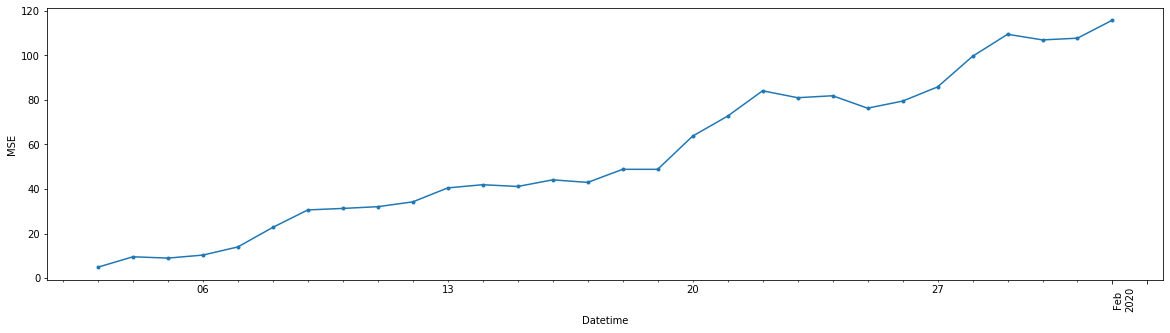

In [18]:
# Plot the mean error in function of the time.
def error_time(serie):
    date = serie.name
    pred_time = pd.DataFrame(df_prediction).transpose()[date]
    error = metrics(serie, pred_time, ERROR).compute()
    return error
    
prediction_time = test.transpose().apply(error_time)

# Show plot.
f = plt.figure(figsize = (20, 5))
prediction_time.plot(ax = f.gca(), style = ".-")
plt.ylabel(ERROR)
plt.xlabel("Datetime")
plt.xticks(rotation = 90)
plt.autoscale()
plt.show()

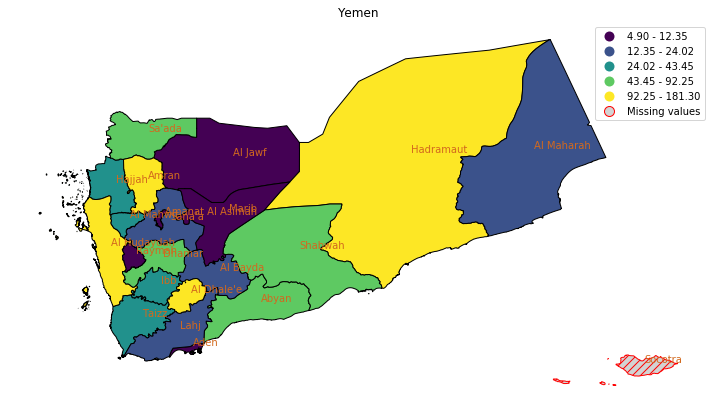

In [19]:
choropleth("Yemen", df.columns.get_level_values(0).unique(), errors, annotation = True, figsize = (15, 7))

In [20]:
# Save the results dataframe.
predictions = pd.DataFrame(df_prediction)
predictions.columns = pd.MultiIndex.from_product([predictions.columns, ["FCS"]])
predictions.columns.names = ["AdminStrata", "Indicator"]

In [21]:
test.to_csv(dir + "/test.csv")
predictions.to_csv(dir + "/HW.csv")